# Jonathan Halverson
# Tuesday, August 29, 2017
# Geron Chapter 2

Create a regression model for the median value of homes in a given district.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
hs = pd.read_csv('geron_housing/housing.csv', header=0)
xs = hs.copy() # make clean copy so that xs is preserved
hs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We see that total_bedrooms has some null values.

In [4]:
hs.describe().applymap(lambda x: round(x, 1))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.0,20640.0,20640.0,20640.0,20433.0,20640.0,20640.0,20640.0,20640.0
mean,-119.6,35.6,28.6,2635.8,537.9,1425.5,499.5,3.9,206855.8
std,2.0,2.1,12.6,2181.6,421.4,1132.5,382.3,1.9,115395.6
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1447.8,296.0,787.0,280.0,2.6,119600.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179700.0
75%,-118.0,37.7,37.0,3148.0,647.0,1725.0,605.0,4.7,264725.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500001.0


Let's look at the one categorical feature:

In [5]:
hs.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

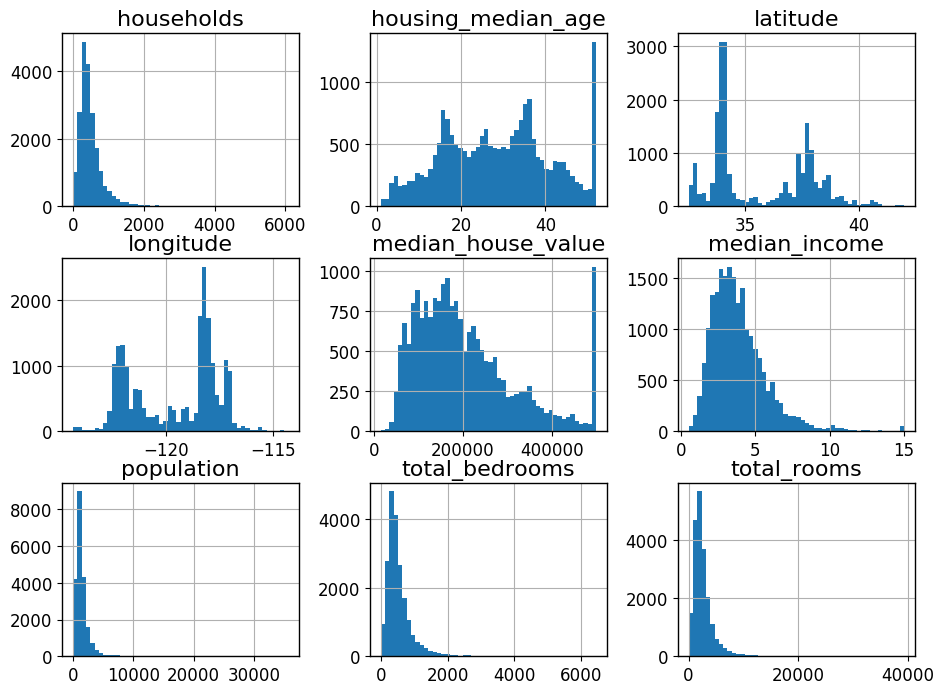

In [6]:
_ = hs.hist(bins=50, figsize=(11, 11 / (4 / 3.0)))

Observations: Some of the distributions are tail heavy and we may consider appling a log or square root transformation. Two predictors are capped at a maximum value. The quantaties are of different scales and need to be stardardized or the like. Not only are the distributions tail heavy but clearly there are points that are more then 3 sigma from the mean. These can potentially be removed (or the removal or inclusion can be treated as a hyperparameter).

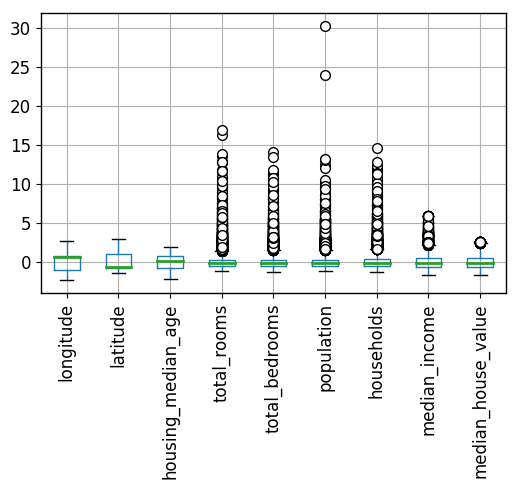

In [7]:
bp = hs.drop('ocean_proximity', axis=1).copy()
((bp - bp.mean()) / bp.std()).boxplot(rot=90)

Create a new feature:

In [8]:
hs['income_cat'] = np.ceil(hs['median_income'] / 1.5)
# Return an object whose corresponding entries are from self where cond is True and otherwise are from other
hs['income_cat'].where(hs['income_cat'] < 5, other=5.0, inplace=True)

In [9]:
hs.income_cat.value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e716510>]], dtype=object)

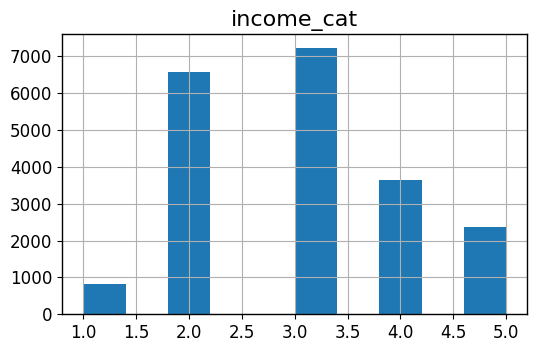

In [10]:
hs.hist('income_cat')

The belief is that income category is an important predictor. In fact, one may take care to ensure that the distribution of records between the test and train sets have the same distribution as the overall income category predictor.

### Create test set

We stop working with the entire data set at this point and create a train and test set. We will put the test set aside and not do anything with it until we have reached our final model.

Here we use the stratify argument to ensure that records in the two partitions have the same distribution of income_cat. Note that random_state is important because over time you solution will see all the test data if the split is done randomly. When more data is added one must be careful how it is dealth with.

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(hs, test_size=0.2, random_state=42, stratify=hs.income_cat)

In [12]:
train.income_cat.value_counts() / train.income_cat.shape[0]

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [13]:
test.income_cat.value_counts() / test.income_cat.shape[0]

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

Now without stratify:

In [14]:
train, test = train_test_split(hs, test_size=0.2, random_state=42)
train.income_cat.value_counts() / train.income_cat.shape[0]

3.0    0.348595
2.0    0.317466
4.0    0.178537
5.0    0.115673
1.0    0.039729
Name: income_cat, dtype: float64

In [15]:
test.income_cat.value_counts() / test.income_cat.shape[0]

3.0    0.358527
2.0    0.324370
4.0    0.167393
5.0    0.109496
1.0    0.040213
Name: income_cat, dtype: float64

In [16]:
# next two lines are needed to avoid warning
train = train.copy()
test = test.copy()

In [17]:
train.drop('income_cat', axis=1, inplace=True)
test.drop('income_cat', axis=1, inplace=True)

In [18]:
hs = train.copy()

We only work with the train set from now on.

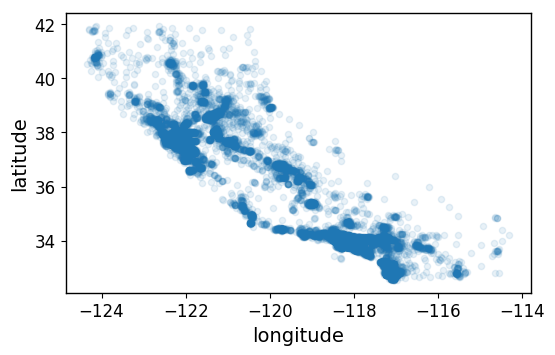

In [19]:
train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

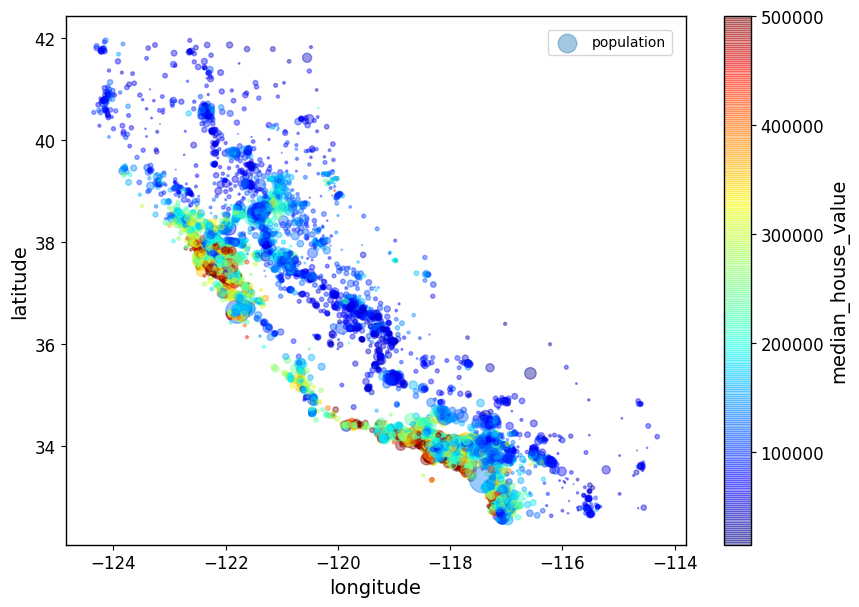

In [20]:
train.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=train["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

It appears median house value is associated with population density. It also appears like there are a few clusters. One could introduce the quantity total value as the product of median house value and population.

In [21]:
hs['total_value'] = hs.population * hs.median_house_value

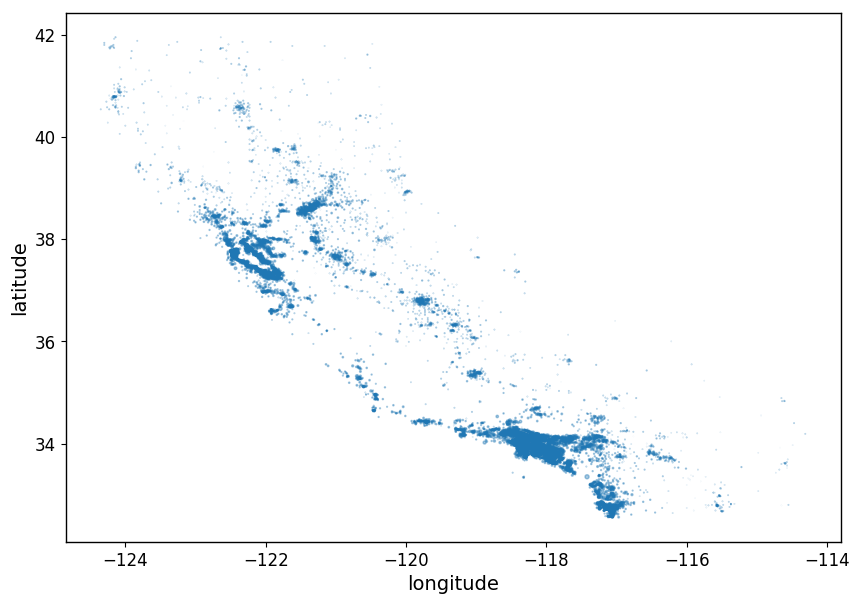

In [22]:
hs.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=10*hs["total_value"]/hs.total_value.max(), figsize=(10,7))

The figure above makes it much easier to see the clusters. They are basically, San Francisco, Sacramento, LA and San Diego.

In [23]:
corr_mat = train.corr().applymap(lambda x: round(x, 2))
corr_mat

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.00,-0.92,-0.10,0.04,0.06,0.09,0.05,-0.02,-0.05
latitude,-0.92,1.00,0.01,-0.03,-0.06,-0.10,-0.06,-0.08,-0.14
housing_median_age,-0.10,0.01,1.00,-0.36,-0.32,-0.29,-0.30,-0.12,0.10
total_rooms,0.04,-0.03,-0.36,1.00,0.93,0.86,0.92,0.20,0.13
total_bedrooms,0.06,-0.06,-0.32,0.93,1.00,0.88,0.98,-0.01,0.05
population,0.09,-0.10,-0.29,0.86,0.88,1.00,0.91,0.00,-0.03
households,0.05,-0.06,-0.30,0.92,0.98,0.91,1.00,0.01,0.06
median_income,-0.02,-0.08,-0.12,0.20,-0.01,0.00,0.01,1.00,0.69
median_house_value,-0.05,-0.14,0.10,0.13,0.05,-0.03,0.06,0.69,1.00


In [24]:
def notable_pairs(cm, thres=0.5):
     dims = cm.shape[0]
     trips = []
     for i in range(dims - 1):
          for j in range(i + 1, dims):
               trips.append((cm.index[i], cm.columns[j], cm.iloc[i, j]))
     trips.sort(cmp=lambda u, v: cmp(abs(u[2]), abs(v[2])), reverse=True)
     for trip in trips:
          if abs(trip[2]) >= thres: print trip[0], trip[1], round(trip[2], 2)

In [25]:
notable_pairs(corr_mat)

total_bedrooms households 0.98
total_rooms total_bedrooms 0.93
longitude latitude -0.92
total_rooms households 0.92
population households 0.91
total_bedrooms population 0.88
total_rooms population 0.86
median_income median_house_value 0.69


In [26]:
hs['bedrooms_per_room'] = hs['total_bedrooms'] / hs['total_rooms']
hs.corr()['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_value           0.478888
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
bedrooms_per_room    -0.257419
Name: median_house_value, dtype: float64

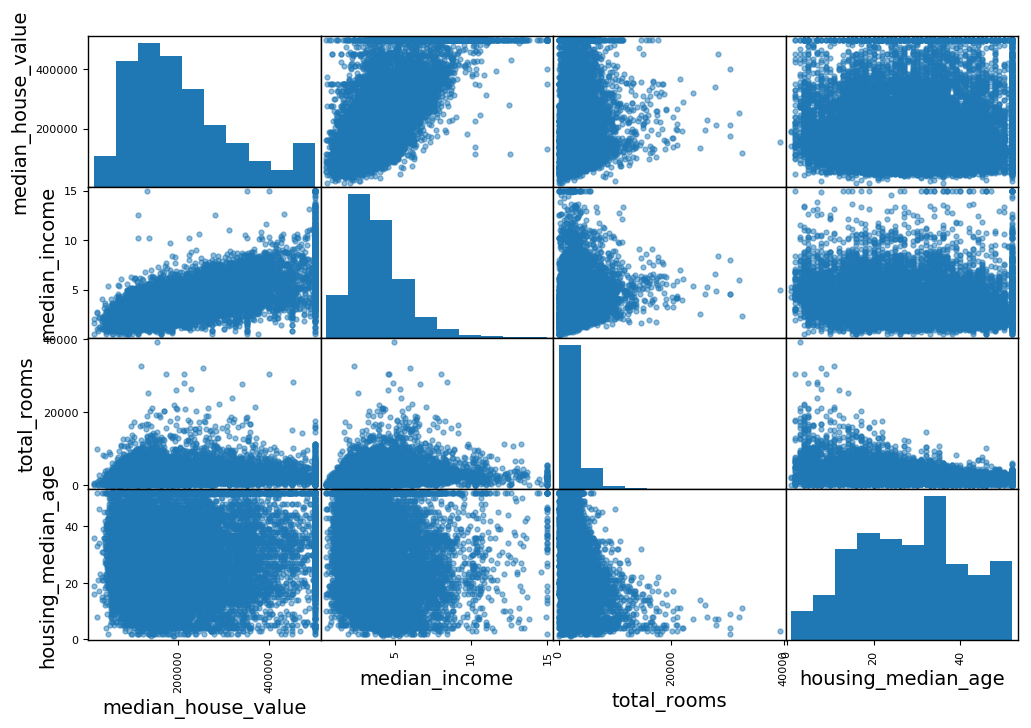

In [27]:
from pandas.tools.plotting import scatter_matrix

atts = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
_ = scatter_matrix(train[atts], figsize=(12, 8))

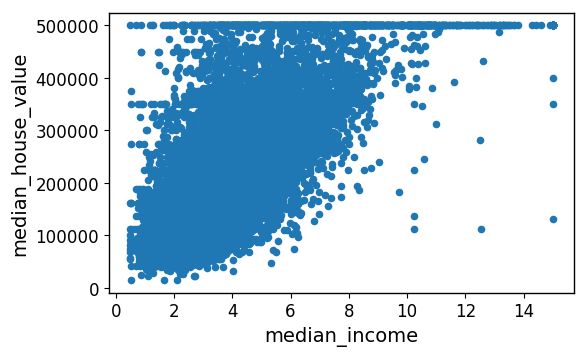

In [28]:
train.plot(kind='scatter', x='median_income', y='median_house_value')

Median income is clearly a reasonable predictor of house value but of course a better model can be obtained by including additional predictors.

So far we have inspected the individual features, checked for outliers and looked at correlations. At this point we already have some simple models in mind. Now let's deal with the messy data.

### Cleaning

In [29]:
hs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_value,bedrooms_per_room
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,236900000.0,0.200576
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,502079400.0,0.232703
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,157929000.0,0.174486
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,132441200.0,0.258269
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,84341000.0,0.180940


In [30]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 12 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
total_value           16512 non-null float64
bedrooms_per_room     16512 non-null float64
dtypes: float64(11), object(1)
memory usage: 1.6+ MB


In [31]:
hs[hs.total_bedrooms.isnull()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_value,bedrooms_per_room


In [32]:
hs.shape

(16512, 12)

In [33]:
# drop any row with an NaN
hs.dropna().shape

(16512, 12)

In [34]:
b_value = hs.total_bedrooms.median()
b_value

437.0

In [35]:
ds = hs.copy()
ds.drop('ocean_proximity', axis=1, inplace=True)
hs['total_bedrooms'].fillna(b_value, inplace=True)
hs[hs.total_bedrooms.isnull()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_value,bedrooms_per_room


In [36]:
hs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 12 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
ocean_proximity       16512 non-null object
total_value           16512 non-null float64
bedrooms_per_room     16512 non-null float64
dtypes: float64(11), object(1)
memory usage: 1.6+ MB


In [37]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 11 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
median_house_value    16512 non-null float64
total_value           16512 non-null float64
bedrooms_per_room     16512 non-null float64
dtypes: float64(11)
memory usage: 1.5 MB


In [38]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')
X = imputer.fit_transform(ds)

Note that X is now a numpy array. To make a dataframe do the following:

In [39]:
df = pd.DataFrame(X, columns=ds.columns)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_value,bedrooms_per_room
0,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,236900000.0,0.200576
1,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,502079400.0,0.232703
2,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,157929000.0,0.174486
3,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,132441200.0,0.258269
4,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,84341000.0,0.180940


#### Handling text and categorical atrributes

In [40]:
hs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,total_value,bedrooms_per_room
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN,236900000.0,0.200576
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN,502079400.0,0.232703
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN,157929000.0,0.174486
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN,132441200.0,0.258269
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND,84341000.0,0.180940


In [41]:
pd.get_dummies(hs).head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_value,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,236900000.0,0.200576,0,0,0,0,1
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,502079400.0,0.232703,0,0,0,0,1
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,157929000.0,0.174486,0,0,0,0,1
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,132441200.0,0.258269,0,0,0,0,1
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,84341000.0,0.180940,0,1,0,0,0


In [42]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
Y = encoder.fit_transform(hs.ocean_proximity)
Y

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ..., 
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [43]:
Z = np.append(X, Y, axis=1)
Z.shape

(16512, 16)

In [44]:
np.c_[X, Y].shape

(16512, 16)

### Custom transformers

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

In [46]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [47]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
     def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
          self.add_bedrooms_per_room = add_bedrooms_per_room
     def fit(self, X, y=None):
          return self
     def transform(self, X, y=None):
          rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
          population_per_household = X[:, population_ix] / X[:, household_ix]
          if self.add_bedrooms_per_room:
               bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
               return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
          else:
               return np.c_[X, rooms_per_household, population_per_household]

In [48]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_atts = attr_adder.transform(hs.values)

In [49]:
housing_extra_atts.shape

(16512, 14)

In [50]:
hs.shape

(16512, 12)

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [52]:
pipeline_num = Pipeline([('imputer', Imputer(strategy='median')),
                         ('attr_addr', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])

In [53]:
hs_num_trans = pipeline_num.fit_transform(Z)
hs_num_trans

array([[ 1.27258656, -1.3728112 ,  0.34849025, ..., -0.17491646,
         0.05137609, -0.2117846 ],
       [ 0.70916212, -0.87669601,  1.61811813, ..., -0.40283542,
        -0.11736222,  0.34218528],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.08821601,
        -0.03227969, -0.66165785],
       ..., 
       [ 0.59946887, -0.75500738,  0.58654547, ..., -0.60675918,
         0.02030568,  0.99951387],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.40217517,
         0.00707608, -0.79086209],
       [-1.41489815,  0.99543676,  1.85617335, ..., -0.85144571,
        -0.08535429,  1.69520292]])

In [54]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
     def __init__(self, attribute_names):
          self.attribute_names = attribute_names
     def fit(self, X, y=None):
          return self
     def transform(self, X, y=None):
          return X[self.attribute_names].values

In [55]:
dfs = DataFrameSelector(hs.columns)
reduced = dfs.transform(hs)
reduced

array([[-117.03, 32.71, 33.0, ..., 'NEAR OCEAN', 236900000.0,
        0.20057581573896352],
       [-118.16, 33.77, 49.0, ..., 'NEAR OCEAN', 502079400.0,
        0.23270254287403902],
       [-120.48, 34.66, 4.0, ..., 'NEAR OCEAN', 157929000.0,
        0.17448603057459147],
       ..., 
       [-118.38, 34.03, 36.0, ..., '<1H OCEAN', 390007600.0,
        0.27082341742027605],
       [-121.96, 37.58, 15.0, ..., '<1H OCEAN', 503779500.0,
        0.16699300699300698],
       [-122.42, 37.77, 52.0, ..., 'NEAR BAY', 851175000.0,
        0.31116895409370565]], dtype=object)

In [56]:
list(ds)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'total_value',
 'bedrooms_per_room']

In [57]:
num_attribs = list(xs.columns)
num_attribs.remove('ocean_proximity')
pipeline_num = Pipeline([('dfs', DataFrameSelector(num_attribs)),
                         ('imputer', Imputer(strategy='median')),
                         ('attr_addr', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())])

In [58]:
cat_attribs = ['ocean_proximity']
pipeline_cat = Pipeline([('dfs', DataFrameSelector(cat_attribs)),
                         ('label_binarizer', LabelBinarizer()),
                         ('std_scaler', StandardScaler())])

In [59]:
from sklearn.pipeline import FeatureUnion

In [60]:
full_pipeline = FeatureUnion([('num_pipe', pipeline_num), ('cat_pipe', pipeline_cat)])

In [61]:
hing = full_pipeline.fit_transform(xs)
hing.shape

/Users/jhalverson/software/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


(20640, 17)

In [62]:
hing.mean(axis=0)

array([ -6.52781016e-15,   1.25626254e-15,   8.55700093e-16,
         1.47518060e-16,  -2.82308092e-16,  -6.46544215e-17,
         2.13935781e-16,   3.73425451e-16,   8.95063524e-16,
         2.70411116e-16,   6.06480843e-19,   6.74809449e-16,
         4.62204241e-14,   2.56162447e-15,  -2.35237127e-15,
        -2.98551397e-14,   2.49039753e-14])

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(hing, xs.median_house_value)
y_pred = lin_reg.predict(hing)

In [64]:
from sklearn.metrics import mean_squared_error, r2_score

print mean_squared_error(xs.median_house_value, y_pred), r2_score(xs.median_house_value, y_pred)

2.77396211099e-20 1.0
